### Human in the Loop



Interrupting the flow to allow the user to provide approval.

We will use breakpoints concept to develop this feature in our graph.

In [1]:
# Let's work out with the reAct agent we created
# in previous videos

from langchain_openai import ChatOpenAI
from langchain.tools import StructuredTool

# Defining tools
def multiply(a:int,b:int) -> int:
    """
    Multiply a and b.
    Args:
    a: first int
    b: second int

    """
    return a*b

def add(a:int,b:int) -> int:
    """
    Adds a and b.

    Args:
    a: first int
    b: second int
    """
    return a+b

def divide(a:int,b:int) -> float:
    """
    Divides a and b

    Args:
    a: first int
    b: second int

    """
    return a/b

adder = StructuredTool.from_function(func = add)
multiplier = StructuredTool.from_function(func = multiply)
divider = StructuredTool.from_function(func = divide)

# Creating the tools list
tools = [adder,multiplier,divider]
llm = ChatOpenAI(model = 'gpt-3.5-turbo')

# Binding the llm with tools
llm_with_tools = llm.bind_tools(tools)


In [2]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Sys message
sys_msg = SystemMessage(content = "You're an assistant adept at performing mathematical operations on a set of input")

# defining the assistant node function
def assistant(state:MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg] + state['messages'])]}

# Instantiating the builder object
builder = StateGraph(MessagesState)

# Define nodes and edges
builder.add_node('assistant',assistant)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',tools_condition)
builder.add_edge('tools','assistant')

# creating a memory object
memory = MemorySaver()

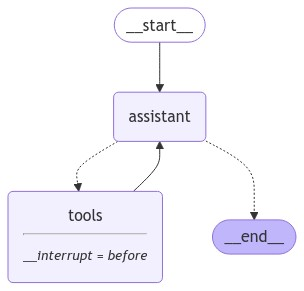

In [4]:
# Compiling the graph
# with checkpointer and interrupt instructions

graph = builder.compile(interrupt_before = ['tools'],
                        checkpointer = memory)

# Visualize
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_state = {'messages': HumanMessage(content = 'Multiply 3 and 5')}

# Configuring thread
config = {'configurable': {'thread_id':'1'}}

# Execute the graph using stream functionality
for event in graph.stream(initial_state,
                          config,
                          stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_04ibWw4AvhbT5K2FmG8I5LX6)
 Call ID: call_04ibWw4AvhbT5K2FmG8I5LX6
  Args:
    a: 3
    b: 5


We can see that the graph has executed till the assistants node and has stopped before the tools node as per the interruption provided by us while compiling it.

In [7]:
# Let's explore the checkpoint of the graph
state = graph.get_state(config)

print(state)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 5', additional_kwargs={}, response_metadata={}, id='e26c8b47-3adf-4c5a-9977-cff71844f846'), HumanMessage(content='Multiply 3 and 5', additional_kwargs={}, response_metadata={}, id='cab3f602-9d96-4320-a628-144b0267bd41'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_04ibWw4AvhbT5K2FmG8I5LX6', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 171, 'total_tokens': 188, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e8d6880-b78f-4209-86ce-657f1a0a6107-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 5}, 'id': 'call_04ibWw4AvhbT5K2FmG8I5LX6', 'type': 'tool_call'}], usage_metadata={'i

Now, one important thing:
When we invoke the graph by providing None as input, it just continues execution from the last checkpoint which is the tool_call or assistant node's response over here.

So, if we run the graph now using None as input then, it will continue from the current state and trigger the tools node and then go towards generating final response.

In [8]:
for event in graph.stream(None,
                          config,
                          stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_04ibWw4AvhbT5K2FmG8I5LX6)
 Call ID: call_04ibWw4AvhbT5K2FmG8I5LX6
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 3 and 5 is 15.


In [ ]:
# Input
initial_state = {"messages": HumanMessage(content="Multiply 3 and 5")}

# Thread
config = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream(initial_state, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_input = input("Should we proceed? (yay/nay): ")

# Check approval
if user_input == "yay":
    
    # If approved, continue the graph execution with None as input
    for event in graph.stream(None,config, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("User denied graph execution")